In [1]:
import os
from PIL import Image 
import torch
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms, datasets, utils
import numpy as np
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torchvision.transforms.functional as TF 
import torch.optim as optim
import torch.nn.functional as F
import pickle
import itertools

In [2]:
def save_variable(a,name):
    with open(name, 'wb') as f:
        pickle.dump(a, f)

def load_variable(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [3]:
class CityscapesDataset(Dataset):
    def __init__(self, split, root_dir, mode='fine', transform=None, eval=False):
        self.transform = transform
        if mode == 'fine':
            self.mode = 'gtFine'
        self.split = split
        self.yLabel_list = []
        self.XImg_list = []
        self.eval = eval

        self.label_path = os.path.join(os.getcwd(), root_dir+'\\'+self.mode+'\\'+self.split)
        self.rgb_path = os.path.join(os.getcwd(), root_dir+'\\leftImg8bit\\'+self.split)
        city_list = os.listdir(self.label_path)
        for city in city_list:
            temp = os.listdir(self.label_path+'/'+city)
            list_items = temp.copy()
            for item in temp:
                if not item.endswith('labelIds.png', 0, len(item)):
                    list_items.remove(item)

            # defining paths
            list_items = ['/'+city+'/'+path for path in list_items]

            self.yLabel_list.extend(list_items)
            self.XImg_list.extend(
                ['/'+city+'/'+path for path in os.listdir(self.rgb_path+'/'+city)]
            )
                
    def __len__(self):
        length = len(self.XImg_list)
        return length      

    def __getitem__(self, index):
        image = Image.open(self.rgb_path+self.XImg_list[index])
        y = Image.open(self.label_path+self.yLabel_list[index])

        if self.transform is not None:
            image = self.transform(image)
            y = self.transform(y)

        image = transforms.ToTensor()(image)
        y = np.array(y)
        y = torch.from_numpy(y)
        y = y.type(torch.LongTensor)
        if self.eval:
            return image, y, self.XImg_list[index]
        else:
            return image, y

def get_cityscapes_data(mode,split,root_dir='datasets\cityscapes',transforms=None,batch_size=1,eval=False,shuffle=True,pin_memory=True):
    data = CityscapesDataset(
        mode=mode, split=split, transform=transforms, root_dir=root_dir, eval=eval)

    data_loaded = torch.utils.data.DataLoader(
        data, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)

    return data_loaded

# Functions to save predictions as images 
def save_as_images(tensor_pred, folder, image_name):
    tensor_pred = transforms.ToPILImage()(tensor_pred.byte())
    filename = f"{folder}\{image_name}.png"
    tensor_pred.save(filename)

In [4]:
class FuzzyLayer(nn.Module):
	def __init__(self, fuzzynum,channel, mu, sigma,static = False):
		super(FuzzyLayer,self).__init__()
		self.n = fuzzynum
		self.channel = channel
		self.conv1 = nn.Conv2d(self.channel,1,3,padding=1)
		self.conv2 = nn.Conv2d(1,self.channel,3,padding=1)
		if not static:
			self.mu = nn.Parameter(torch.randn((self.channel,self.n,6,13)))
			self.sigma = nn.Parameter(torch.randn((self.channel,self.n,6,13)))
		else:
			self.mu = mu
			self.sigma = sigma
		self.weight = range(10,10*(self.n + 1),10)	
		self.bn1 = nn.BatchNorm2d(1, affine=True)	
		self.bn2 = nn.BatchNorm2d(self.channel,affine=True)

	def forward(self, x):
		x = self.conv1(x)
		tmp = torch.tensor(np.zeros((x.size()[0],x.size()[1],x.size()[2],x.size()[3])),dtype = torch.float).cuda()
		for num,channel,w,h in itertools.product(range(x.size()[0]),range(x.size()[1]),range(x.size()[2]),range(x.size()[3])):
			for f in range(self.n):
				tmp[num][channel][w][h] += self.weight[f] * torch.exp(-((x[num][channel][w][h]-self.mu[channel][f][w][h])/(np.sqrt(2) * self.sigma[channel][f][w][h]))**2)
		fuzzy = self.bn2(self.conv2(self.bn1(tmp)))
		return fuzzy	

In [5]:
class Fuzzy_UNET(nn.Module):
    
    def __init__(self, mu, sigma, in_channels=3, classes=1, static = False, fuzzy = False):
        super(Fuzzy_UNET, self).__init__()
        self.layers = [in_channels, 64, 128, 256]
        self.double_conv_downs = nn.ModuleList(
            [self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])]) 
        self.up_trans = nn.ModuleList(
            [nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2)
             for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])
        self.double_conv_ups = nn.ModuleList(
        [self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.final_conv = nn.Conv2d(64, classes, kernel_size=1)
        self.fuzzy = FuzzyLayer(fuzzynum=4,channel=self.layers[-1], mu = mu, sigma = sigma, static = static)
        self.f = fuzzy


    def __double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv
    
    def forward(self, x):
        # down layers
        concat_layers = []
        for down in self.double_conv_downs:
            x = down(x)
            if down != self.double_conv_downs[-1]:
                concat_layers.append(x)
                x = self.max_pool_2x2(x)
                
        x = self.max_pool_2x2(x)
        if self.f:
            x = self.max_pool_2x2(x)
            x = self.fuzzy(x)
        
        concat_layers = concat_layers[::-1]
        
        # up layers
        for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
            x = up_trans(x)
            if x.shape != concat_layer.shape:
                x = TF.resize(x, concat_layer.shape[2:])
            
            concatenated = torch.cat((concat_layer, x), dim=1)
            x = double_conv_up(concatenated)
            
        x = self.final_conv(x)
        
        return x 


In [6]:
if torch.cuda.is_available():
    DEVICE = 'cuda:0'
    print('Running on the GPU')
else:
    DEVICE = "cpu"
    print('Running on the CPU')

Running on the GPU


In [7]:
def accuracy_calculation(pred, label):
    torch.cuda.empty_cache()
    pred_class = torch.argmax(pred, dim=1) 
    pred_class = pred_class.float()
    acc_sum = (pred_class == label).sum()
    acc = float(acc_sum) / torch.numel(label)
    return acc

def acc_epoch(data, model,device):
    acc = []
    for index, batch in enumerate(data): 
        X, y = batch
        X, y = X.to(device), y.to(device)
        preds = model(X)
        acc_ = accuracy_calculation(preds,y)
        acc.append(acc_)
    return np.mean(acc)


In [8]:
ROOT_DIR = "datasets\\cityscapes"
IMG_HEIGHT = 110  
IMG_WIDTH = 220  
BATCH_SIZE = 32 
LEARNING_RATE = 0.0003
EPOCHS = 50

transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=Image.NEAREST),
]) 

train_set = get_cityscapes_data(
    split='train',
    mode='fine',
    root_dir=ROOT_DIR,
    transforms=transform,
    batch_size=BATCH_SIZE,
)

test_set = get_cityscapes_data(
    split='val',
    mode='fine',
    root_dir=ROOT_DIR,
    transforms=transform,
    batch_size=16,
)

def train_function(data, model, optimizer, loss_fn, device):
    print('Entering into train function')
    loss_values = []
    data = tqdm(data)
    for index, batch in enumerate(data): 
        X, y = batch
        X, y = X.to(device), y.to(device)
        preds = model(X)
        loss = loss_fn(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.item()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_28072\3372100886.py:9: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  transforms.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=Image.NEAREST),


In [9]:
LOSS_VALS_Fuzzy = []
ACC_VALS_Fuzzy = []

unet_fuzzy = Fuzzy_UNET(0, 0,in_channels=3, classes=35, fuzzy = True).to(DEVICE).train()
optimizer = optim.Adam(unet_fuzzy.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss().to(DEVICE)

for e in range(0, EPOCHS):
    torch.cuda.empty_cache()
    print(f'Epoch: {e}')
    loss_val = train_function(train_set, unet_fuzzy, optimizer, loss_function, DEVICE)
    LOSS_VALS_Fuzzy.append(loss_val) 
    print(f'Loss = {loss_val}')
    torch.cuda.empty_cache()
    acc = acc_epoch(test_set, unet_fuzzy, DEVICE)
    ACC_VALS_Fuzzy.append(acc)
    print(f'Acc = {acc}')
    save_variable(unet_fuzzy.fuzzy.mu,'unet_fuzzy_mu_' + str(e) + '.txt')
    save_variable(unet_fuzzy.fuzzy.sigma,'unet_fuzzy_sigma_' + str(e) + '.txt')

save_variable(unet_fuzzy,'unet_fuzzy.txt')
save_variable(LOSS_VALS_Fuzzy,'loss_unet_fuzzy.txt')
save_variable(ACC_VALS_Fuzzy,'acc_unet_fuzzy.txt')

Epoch: 0
Entering into train function


  0%|          | 0/93 [00:00<?, ?it/s]c:\Users\ASUS\.conda\envs\pytorch\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 93/93 [14:43<00:00,  9.50s/it]


Loss = 0.9830297827720642
Acc = 0.7315295712809917
Epoch: 1
Entering into train function


100%|██████████| 93/93 [12:15<00:00,  7.91s/it]


Loss = 0.8877419233322144
Acc = 0.7788714650051654
Epoch: 2
Entering into train function


100%|██████████| 93/93 [12:15<00:00,  7.91s/it]


Loss = 0.7258073687553406
Acc = 0.7934044098657025
Epoch: 3
Entering into train function


100%|██████████| 93/93 [12:14<00:00,  7.90s/it]


Loss = 0.6938217878341675
Acc = 0.7979471203512396
Epoch: 4
Entering into train function


100%|██████████| 93/93 [12:15<00:00,  7.90s/it]


Loss = 0.678350567817688
Acc = 0.8065276342975206
Epoch: 5
Entering into train function


100%|██████████| 93/93 [12:18<00:00,  7.94s/it]


Loss = 0.6140825152397156
Acc = 0.8153483341942149
Epoch: 6
Entering into train function


100%|██████████| 93/93 [12:18<00:00,  7.94s/it]


Loss = 0.541427731513977
Acc = 0.8103643143078513
Epoch: 7
Entering into train function


100%|██████████| 93/93 [12:14<00:00,  7.89s/it]


Loss = 0.49845150113105774
Acc = 0.8184451672262396
Epoch: 8
Entering into train function


100%|██████████| 93/93 [12:14<00:00,  7.90s/it]


Loss = 0.6432481408119202
Acc = 0.8176292129390496
Epoch: 9
Entering into train function


100%|██████████| 93/93 [12:16<00:00,  7.92s/it]


Loss = 0.5191582441329956
Acc = 0.8293289966425621
Epoch: 10
Entering into train function


100%|██████████| 93/93 [12:13<00:00,  7.89s/it]


Loss = 0.6112388372421265
Acc = 0.8268272210743801
Epoch: 11
Entering into train function


100%|██████████| 93/93 [12:20<00:00,  7.96s/it]


Loss = 0.5472810864448547
Acc = 0.8285390302169422
Epoch: 12
Entering into train function


100%|██████████| 93/93 [12:15<00:00,  7.91s/it]


Loss = 0.45748355984687805
Acc = 0.8337894660382232
Epoch: 13
Entering into train function


100%|██████████| 93/93 [12:13<00:00,  7.89s/it]


Loss = 0.6775178909301758
Acc = 0.7923671552169421
Epoch: 14
Entering into train function


100%|██████████| 93/93 [12:21<00:00,  7.97s/it]


Loss = 0.5578784942626953
Acc = 0.8325288126291323
Epoch: 15
Entering into train function


100%|██████████| 93/93 [12:12<00:00,  7.88s/it]


Loss = 0.4503972828388214
Acc = 0.835650180785124
Epoch: 16
Entering into train function


100%|██████████| 93/93 [12:19<00:00,  7.96s/it]


Loss = 0.5257447361946106
Acc = 0.8384572733729339
Epoch: 17
Entering into train function


100%|██████████| 93/93 [12:13<00:00,  7.89s/it]


Loss = 0.5556102395057678
Acc = 0.8396604629390496
Epoch: 18
Entering into train function


100%|██████████| 93/93 [12:13<00:00,  7.89s/it]


Loss = 0.5479447841644287
Acc = 0.8383283025568182
Epoch: 19
Entering into train function


100%|██████████| 93/93 [12:16<00:00,  7.92s/it]


Loss = 0.5545976161956787
Acc = 0.839710259555785
Epoch: 20
Entering into train function


100%|██████████| 93/93 [12:15<00:00,  7.91s/it]


Loss = 0.51969975233078
Acc = 0.8321234988378099
Epoch: 21
Entering into train function


100%|██████████| 93/93 [12:15<00:00,  7.91s/it]


Loss = 0.46446967124938965
Acc = 0.8394111570247933
Epoch: 22
Entering into train function


100%|██████████| 93/93 [12:12<00:00,  7.88s/it]


Loss = 0.5353295803070068
Acc = 0.8348855565599174
Epoch: 23
Entering into train function


100%|██████████| 93/93 [12:16<00:00,  7.92s/it]


Loss = 0.4502638876438141
Acc = 0.8438432980371902
Epoch: 24
Entering into train function


100%|██████████| 93/93 [12:13<00:00,  7.89s/it]


Loss = 0.44197094440460205
Acc = 0.8411600109762396
Epoch: 25
Entering into train function


100%|██████████| 93/93 [12:22<00:00,  7.98s/it]


Loss = 0.4570598304271698
Acc = 0.8394615993026859
Epoch: 26
Entering into train function


100%|██████████| 93/93 [12:13<00:00,  7.88s/it]


Loss = 0.5248688459396362
Acc = 0.8348686079545454
Epoch: 27
Entering into train function


100%|██████████| 93/93 [12:15<00:00,  7.91s/it]


Loss = 0.520176351070404
Acc = 0.8366926007231406
Epoch: 28
Entering into train function


100%|██████████| 93/93 [12:13<00:00,  7.89s/it]


Loss = 0.4497784376144409
Acc = 0.8440521694214876
Epoch: 29
Entering into train function


100%|██████████| 93/93 [12:15<00:00,  7.91s/it]


Loss = 0.41178107261657715
Acc = 0.8457322604597108
Epoch: 30
Entering into train function


100%|██████████| 93/93 [12:17<00:00,  7.93s/it]


Loss = 0.45659705996513367
Acc = 0.8447972623966942
Epoch: 31
Entering into train function


100%|██████████| 93/93 [12:12<00:00,  7.87s/it]


Loss = 0.40684062242507935
Acc = 0.8414835679235537
Epoch: 32
Entering into train function


100%|██████████| 93/93 [12:18<00:00,  7.95s/it]


Loss = 0.39187362790107727
Acc = 0.8436218362603306
Epoch: 33
Entering into train function


100%|██████████| 93/93 [12:10<00:00,  7.86s/it]


Loss = 0.4561930298805237
Acc = 0.8453038642820248
Epoch: 34
Entering into train function


100%|██████████| 93/93 [12:20<00:00,  7.97s/it]


Loss = 0.4398045539855957
Acc = 0.8409929461518595
Epoch: 35
Entering into train function


100%|██████████| 93/93 [12:12<00:00,  7.87s/it]


Loss = 0.45760005712509155
Acc = 0.8394672488378099
Epoch: 36
Entering into train function


100%|██████████| 93/93 [12:09<00:00,  7.85s/it]


Loss = 0.5246810913085938
Acc = 0.8409395983987603
Epoch: 37
Entering into train function


100%|██████████| 93/93 [12:19<00:00,  7.95s/it]


Loss = 0.5515089631080627
Acc = 0.8321301168646694
Epoch: 38
Entering into train function


100%|██████████| 93/93 [12:17<00:00,  7.93s/it]


Loss = 0.41721946001052856
Acc = 0.8444702350206612
Epoch: 39
Entering into train function


100%|██████████| 93/93 [12:13<00:00,  7.89s/it]


Loss = 0.4913797974586487
Acc = 0.8456217716942148
Epoch: 40
Entering into train function


100%|██████████| 93/93 [12:14<00:00,  7.90s/it]


Loss = 0.4886768162250519
Acc = 0.8390573347107438
Epoch: 41
Entering into train function


100%|██████████| 93/93 [12:14<00:00,  7.90s/it]


Loss = 0.5523442625999451
Acc = 0.8427768272210743
Epoch: 42
Entering into train function


100%|██████████| 93/93 [12:14<00:00,  7.90s/it]


Loss = 0.4118516743183136
Acc = 0.8504792419938016
Epoch: 43
Entering into train function


100%|██████████| 93/93 [12:22<00:00,  7.98s/it]


Loss = 0.37737786769866943
Acc = 0.8496488410382231
Epoch: 44
Entering into train function


100%|██████████| 93/93 [12:12<00:00,  7.88s/it]


Loss = 0.39891567826271057
Acc = 0.8508186983471073
Epoch: 45
Entering into train function


100%|██████████| 93/93 [12:16<00:00,  7.91s/it]


Loss = 0.416339635848999
Acc = 0.8491859826962809
Epoch: 46
Entering into train function


100%|██████████| 93/93 [12:16<00:00,  7.92s/it]


Loss = 0.4381870627403259
Acc = 0.8493523211518595
Epoch: 47
Entering into train function


100%|██████████| 93/93 [12:14<00:00,  7.90s/it]


Loss = 0.4164195656776428
Acc = 0.8483529990960743
Epoch: 48
Entering into train function


 26%|██▌       | 24/93 [03:24<10:25,  9.07s/it]

In [ ]:
LOSS_VALS = []
ACC_VALS = []

unet = Fuzzy_UNET(0, 0 , in_channels=3, classes=35).to(DEVICE).train()
optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss().to(DEVICE)

for e in range(0, EPOCHS):
    torch.cuda.empty_cache()
    print(f'Epoch: {e}')
    loss_val = train_function(train_set, unet, optimizer, loss_function, DEVICE)
    LOSS_VALS.append(loss_val) 
    print(f'Loss = {loss_val}')
    torch.cuda.empty_cache()
    acc = acc_epoch(test_set, unet, DEVICE)
    ACC_VALS.append(acc)
    print(f'Acc = {acc}')

save_variable(unet,'unet.txt')
save_variable(LOSS_VALS,'loss_unet.txt')
save_variable(ACC_VALS,'acc_unet.txt')

Epoch: 0
Entering into train function


 26%|██▌       | 24/93 [00:37<01:49,  1.58s/it]


KeyboardInterrupt: 

In [ ]:
LOSS_VALS_Static = []
ACC_VALS_Static = []

mu = load_variable('unet_fuzzy_mu_5.txt')
sigma = load_variable('unet_fuzzy_sigma_5.txt')
unet_static = Fuzzy_UNET(mu=mu,sigma=sigma,in_channels=3, classes=35,static =True, fuzzy = True).to(DEVICE).train()
optimizer = optim.Adam(unet_static.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss().to(DEVICE)

for e in range(0, EPOCHS):
    torch.cuda.empty_cache()
    print(f'Epoch: {e}')
    loss_val = train_function(train_set, unet_static, optimizer, loss_function, DEVICE)
    LOSS_VALS_Static.append(loss_val) 
    print(f'Loss = {loss_val}')
    torch.cuda.empty_cache()
    acc = acc_epoch(test_set, unet_static, DEVICE)
    ACC_VALS_Static.append(acc)
    print(f'Acc = {acc}')

save_variable(unet_static,'unet_static.txt')
save_variable(LOSS_VALS_Static,'loss_unet_static.txt')
save_variable(ACC_VALS_Static,'acc_unet_static.txt')

Epoch: 0
Entering into train function


100%|██████████| 93/93 [12:13<00:00,  7.89s/it]


Loss = 1.055131196975708
Acc = 0.7282619608729339
Epoch: 1
Entering into train function


100%|██████████| 93/93 [11:52<00:00,  7.66s/it]


Loss = 0.6399616599082947
Acc = 0.7828286415289256
Epoch: 2
Entering into train function


100%|██████████| 93/93 [12:06<00:00,  7.81s/it]


Loss = 0.7874130010604858
Acc = 0.7880604338842976
Epoch: 3
Entering into train function


100%|██████████| 93/93 [12:09<00:00,  7.84s/it]


Loss = 0.5947115421295166
Acc = 0.8063078673811983
Epoch: 4
Entering into train function


100%|██████████| 93/93 [12:00<00:00,  7.74s/it]


Loss = 0.678134560585022
Acc = 0.8058550167871901
Epoch: 5
Entering into train function


100%|██████████| 93/93 [12:14<00:00,  7.89s/it]


Loss = 0.53728187084198
Acc = 0.8210796261621901
Epoch: 6
Entering into train function


100%|██████████| 93/93 [12:08<00:00,  7.83s/it]


Loss = 0.5248477458953857
Acc = 0.8211445151084711
Epoch: 7
Entering into train function


100%|██████████| 93/93 [12:16<00:00,  7.92s/it]


Loss = 0.5786038637161255
Acc = 0.8184357244318182
Epoch: 8
Entering into train function


100%|██████████| 93/93 [12:06<00:00,  7.82s/it]


Loss = 0.4909683167934418
Acc = 0.8243949347882232
Epoch: 9
Entering into train function


100%|██████████| 93/93 [11:54<00:00,  7.68s/it]


Loss = 0.45408037304878235
Acc = 0.8267489346590908
Epoch: 10
Entering into train function


100%|██████████| 93/93 [12:09<00:00,  7.84s/it]


Loss = 0.48830750584602356
Acc = 0.8326535059400826
Epoch: 11
Entering into train function


100%|██████████| 93/93 [12:16<00:00,  7.92s/it]


Loss = 0.5547605156898499
Acc = 0.8357903699638429
Epoch: 12
Entering into train function


100%|██████████| 93/93 [12:07<00:00,  7.82s/it]


Loss = 0.41669929027557373
Acc = 0.8339433755165289
Epoch: 13
Entering into train function


100%|██████████| 93/93 [12:03<00:00,  7.78s/it]


Loss = 0.43424054980278015
Acc = 0.835617171358471
Epoch: 14
Entering into train function


100%|██████████| 93/93 [12:01<00:00,  7.76s/it]


Loss = 0.4587761461734772
Acc = 0.8347405249225206
Epoch: 15
Entering into train function


100%|██████████| 93/93 [12:03<00:00,  7.78s/it]


Loss = 0.44202563166618347
Acc = 0.8331162028667356
Epoch: 16
Entering into train function


100%|██████████| 93/93 [12:07<00:00,  7.82s/it]


Loss = 0.3941418528556824
Acc = 0.8366005940082644
Epoch: 17
Entering into train function


100%|██████████| 93/93 [12:05<00:00,  7.80s/it]


Loss = 0.3387136459350586
Acc = 0.8415724270402893
Epoch: 18
Entering into train function


100%|██████████| 93/93 [12:09<00:00,  7.85s/it]


Loss = 0.4315679967403412
Acc = 0.8387069021177687
Epoch: 19
Entering into train function


100%|██████████| 93/93 [12:12<00:00,  7.88s/it]


Loss = 0.31384167075157166
Acc = 0.8363851045971075
Epoch: 20
Entering into train function


100%|██████████| 93/93 [11:54<00:00,  7.68s/it]


Loss = 0.4108540117740631
Acc = 0.8372945990444215
Epoch: 21
Entering into train function


100%|██████████| 93/93 [12:14<00:00,  7.90s/it]


Loss = 0.4022478461265564
Acc = 0.8374599690082645
Epoch: 22
Entering into train function


100%|██████████| 93/93 [12:22<00:00,  7.99s/it]


Loss = 0.36003419756889343
Acc = 0.8433130488119835
Epoch: 23
Entering into train function


100%|██████████| 93/93 [12:17<00:00,  7.93s/it]


Loss = 0.39005714654922485
Acc = 0.8389250548811983
Epoch: 24
Entering into train function


100%|██████████| 93/93 [12:04<00:00,  7.79s/it]


Loss = 0.39738667011260986
Acc = 0.8426158154700414
Epoch: 25
Entering into train function


100%|██████████| 93/93 [12:17<00:00,  7.93s/it]


Loss = 0.33463171124458313
Acc = 0.8446053396177686
Epoch: 26
Entering into train function


100%|██████████| 93/93 [12:11<00:00,  7.86s/it]


Loss = 0.3872620761394501
Acc = 0.8401339746900827
Epoch: 27
Entering into train function


100%|██████████| 93/93 [12:00<00:00,  7.74s/it]


Loss = 0.34386229515075684
Acc = 0.8414466845299586
Epoch: 28
Entering into train function


100%|██████████| 93/93 [12:15<00:00,  7.91s/it]


Loss = 0.331616073846817
Acc = 0.8432322604597107
Epoch: 29
Entering into train function


100%|██████████| 93/93 [12:00<00:00,  7.75s/it]


Loss = 0.2847960591316223
Acc = 0.8459507360537191
Epoch: 30
Entering into train function


100%|██████████| 93/93 [12:23<00:00,  8.00s/it]


Loss = 0.34817105531692505
Acc = 0.8462803460743802
Epoch: 31
Entering into train function


100%|██████████| 93/93 [12:03<00:00,  7.78s/it]


Loss = 0.375699907541275
Acc = 0.8432881101497934
Epoch: 32
Entering into train function


100%|██████████| 93/93 [11:50<00:00,  7.64s/it]


Loss = 0.4328402280807495
Acc = 0.8358370996900827
Epoch: 33
Entering into train function


100%|██████████| 93/93 [12:06<00:00,  7.82s/it]


Loss = 0.37191203236579895
Acc = 0.8447623966942148
Epoch: 34
Entering into train function


100%|██████████| 93/93 [12:24<00:00,  8.01s/it]


Loss = 0.34936442971229553
Acc = 0.8458872998450413
Epoch: 35
Entering into train function


100%|██████████| 93/93 [12:11<00:00,  7.87s/it]


Loss = 0.3089505136013031
Acc = 0.8476376872417355
Epoch: 36
Entering into train function


100%|██████████| 93/93 [12:22<00:00,  7.98s/it]


Loss = 0.3151458203792572
Acc = 0.8454802911931818
Epoch: 37
Entering into train function


100%|██████████| 93/93 [14:01<00:00,  9.05s/it]


Loss = 0.3559150993824005
Acc = 0.8455171745867769
Epoch: 38
Entering into train function


100%|██████████| 93/93 [12:39<00:00,  8.16s/it]


Loss = 0.2630380094051361
Acc = 0.8447548101756198
Epoch: 39
Entering into train function


100%|██████████| 93/93 [12:42<00:00,  8.20s/it]


Loss = 0.2771966755390167
Acc = 0.8481521984762397
Epoch: 40
Entering into train function


100%|██████████| 93/93 [12:50<00:00,  8.28s/it]


Loss = 0.27754899859428406
Acc = 0.8432410575929752
Epoch: 41
Entering into train function


100%|██████████| 93/93 [12:30<00:00,  8.07s/it]


Loss = 0.3187815248966217
Acc = 0.8466453867510331
Epoch: 42
Entering into train function


100%|██████████| 93/93 [12:43<00:00,  8.21s/it]


Loss = 0.28928422927856445
Acc = 0.845105242768595
Epoch: 43
Entering into train function


100%|██████████| 93/93 [12:47<00:00,  8.25s/it]


Loss = 0.36306411027908325
Acc = 0.8462477401859505
Epoch: 44
Entering into train function


100%|██████████| 93/93 [12:56<00:00,  8.35s/it]


Loss = 0.2734547257423401
Acc = 0.8488446700671488
Epoch: 45
Entering into train function


100%|██████████| 93/93 [13:00<00:00,  8.39s/it]


Loss = 0.28526321053504944
Acc = 0.8471903247675621
Epoch: 46
Entering into train function


100%|██████████| 93/93 [12:52<00:00,  8.31s/it]


Loss = 0.27154237031936646
Acc = 0.8444521565082644
Epoch: 47
Entering into train function


100%|██████████| 93/93 [12:15<00:00,  7.91s/it]


Loss = 0.2894633710384369
Acc = 0.8453993414256198
Epoch: 48
Entering into train function


100%|██████████| 93/93 [12:20<00:00,  7.96s/it]


Loss = 0.299468070268631
Acc = 0.8477417193956611
Epoch: 49
Entering into train function


100%|██████████| 93/93 [12:19<00:00,  7.95s/it]


Loss = 0.2743155062198639
Acc = 0.8489261847882231


In [ ]:
import matplotlib.pyplot as plt

def plot_(fuzzy = np.ones(EPOCHS),unet = np.ones(EPOCHS),static = np.ones(EPOCHS), name = ""):
    plt.plot(range(0,EPOCHS),fuzzy)
    plt.plot(range(0,EPOCHS),unet)
    plt.plot(range(0,EPOCHS),static)
    plt.legend([name + '_Fuzzy',name + '_Origin',name + '_Static'],loc='center right')
    plt.title(name)
    plt.show()


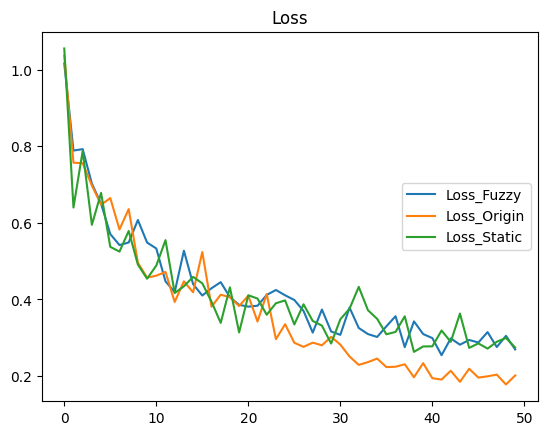

In [ ]:
loss_fuzzy = load_variable('loss_unet_fuzzy.txt')
loss_unet = load_variable('loss_unet.txt')
loss_static = load_variable('loss_unet_static.txt')
plot_(fuzzy = loss_fuzzy, unet=loss_unet,static=loss_static,name = "Loss")

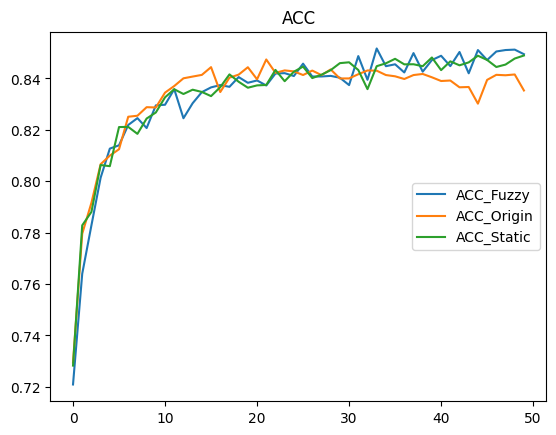

In [ ]:
acc_fuzzy = load_variable('acc_unet_fuzzy.txt')
acc_unet = load_variable('acc_unet.txt')
acc_static = load_variable('acc_unet_static.txt')
plot_(fuzzy = acc_fuzzy, unet=acc_unet,static=acc_static, name = "ACC")

c:\Users\ASUS\.conda\envs\pytorch\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


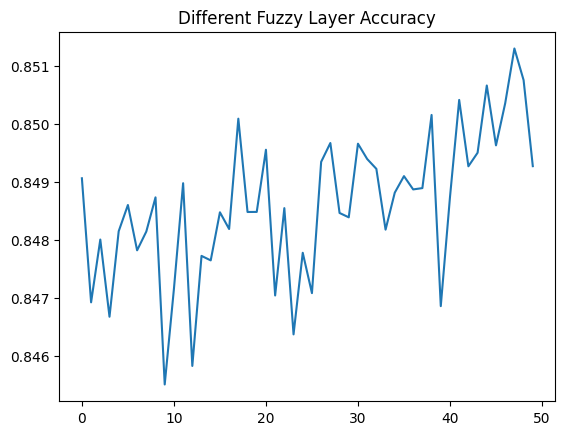

In [ ]:
def fuzzy_parameter_test():
    unet_fuzzy = load_variable('unet_fuzzy.txt')
    ACC = []
    for i in range(0,EPOCHS):
        mu = load_variable('unet_fuzzy_mu_' + str(i) + '.txt')
        sigma = load_variable('unet_fuzzy_sigma_' + str(i) + '.txt')
        unet_fuzzy.fuzzy.mu = mu
        unet_fuzzy.fuzzy.sigma = sigma
        ACC.append(acc_epoch(test_set,unet_fuzzy,DEVICE))
    plt.plot(range(0,EPOCHS),ACC)
    plt.title('Different Fuzzy Layer Accuracy')
    plt.show()

fuzzy_parameter_test()

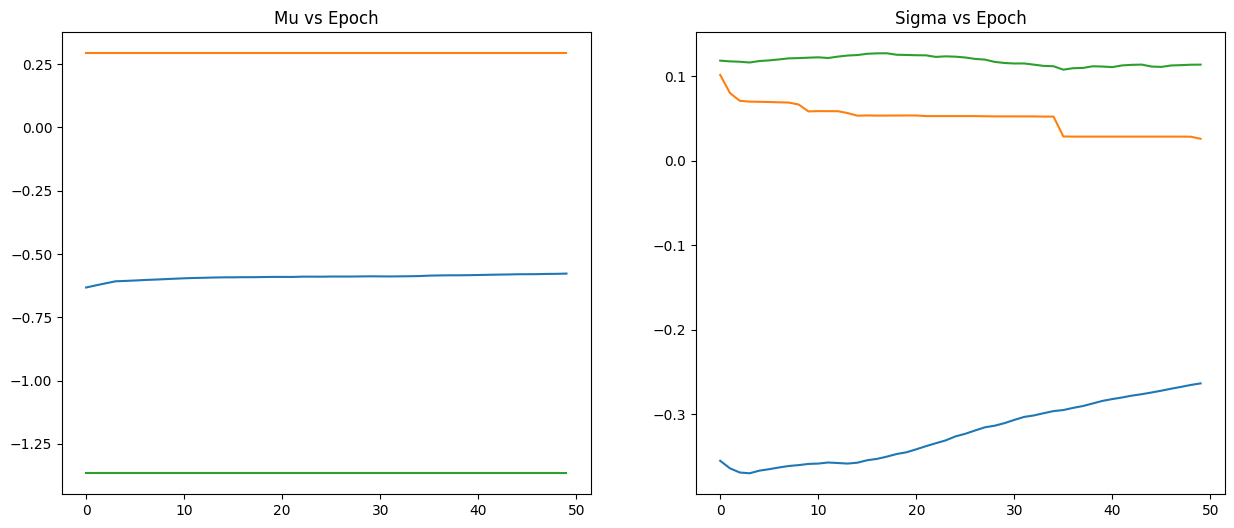

In [ ]:
def plot_parameter():
    plt.figure(figsize=(15,6))
    mu_1 = []
    mu_2 = []
    mu_3 = []

    sigma_1 = []
    sigma_2 = []
    sigma_3 = []
    for i in range(0,EPOCHS):
        mu_ = load_variable('unet_fuzzy_mu_' + str(i) + '.txt')
        mu_1.append(mu_[0][0].to('cpu').detach().numpy())
        mu_2.append(mu_[1][0].to('cpu').detach().numpy())
        mu_3.append(mu_[2][0].to('cpu').detach().numpy())

        sigma_ = load_variable('unet_fuzzy_sigma_' + str(i) + '.txt')
        sigma_1.append(sigma_[0][0].to('cpu').detach().numpy())
        sigma_2.append(sigma_[0][1].to('cpu').detach().numpy())
        sigma_3.append(sigma_[0][2].to('cpu').detach().numpy())
    plt.subplot(1,2,1)
    ax1 = plt.subplot(121)
    ax1.plot(range(0,EPOCHS),mu_1)
    ax1.plot(range(0,EPOCHS),mu_2)
    ax1.plot(range(0,EPOCHS),mu_3)
    ax1.set_title('Mu vs Epoch')
    ax2 = plt.subplot(122)
    ax2.plot(range(0,EPOCHS),sigma_1)
    ax2.plot(range(0,EPOCHS),sigma_2)
    ax2.plot(range(0,EPOCHS),sigma_3)
    ax2.set_title('Sigma vs Epoch')
    plt.show()

plot_parameter()